# MLModel Fairness guide

## Table of Contents <a class="anchor" id="0"></a>
* [Introduction](#1) 
* [Fairness Analysis for Classification](#4)
    * [Load model architecture](#2)
    * [ML Model Training](#3)
    * [Estimate Model Fairness of Base Model](#4)   
    * [Choosing a Metric](#9)   
    * [Bias mitigation ](#23)
    * [Estimate Model Fairness of Mitigated Model](#24)
* [Fairness Analysis for Regression](#4)
    * [Load model architecture](#2)
    * [ML Model Training](#3)
    * [Estimate Model Fairness of Base Model](#4)   
    * [Choosing a Metric](#9)   
    * [Bias mitigation ](#23)
    * [Estimate Model Fairness of Mitigated Model](#24)
* [Summary](#25)

## Introduction <a class="anchor" id="1"></a>

Bias in machine learning models can lead to unfair and discriminatory outcomes, especially when trained on historical data reflecting societal inequalities. This guide provides an overview of how to estimate and mitigate bias using [MLModel]() with backbones such as Random Forest, Gradient Boosting, LightGBM etc. and other available scikit-learn algorithms.

The `arcgis.learn` module includes [MLModel](https://developers.arcgis.com/python/api-reference/arcgis.learn.toc.html#mlmodel) classes to train machine learning and deep learning models on tabular data which can be any vector data in the form of a [feature layer](https://developers.arcgis.com/python/guide/working-with-feature-layers-and-features/) or [spatially enabled dataframe](https://developers.arcgis.com/python/guide/introduction-to-the-spatially-enabled-dataframe/).  The `MLModel` uses machine learning algorithms to train models and  allows you to use any [regression](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning) or [classification](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning) model from scikit-learn.


Here we will learn techniques to first identify bias in models with respect to features or variables which are prone to bias also called as sensitive features, and practical strategies to reduce unfairness following appropriate mitigation strategies, ensuring more equitable and unbiased models. By applying these methods, arcgis.learn api developers can create models for tabular data that make fairer decisions across diverse groups and minimize the risk of discrimination. Currenlty we support both classification and regression modeling for estimating fairness.

## Fairness Analysis for Classification

Here we will discuss fairness estimation for classification.

## Prepare tabular data <a class="anchor" id="2"></a>

First we will start by creating the `TabularDataObject` using  `prepare_tabulardata()` method that can be fed into the `MLModel`, then initializing the model and then fitting the model. Refer to the [Machine learning and deep learning on tabular data](https://developers.arcgis.com/python/latest/guide/ml-and-dl-on-tabular-data/) documentation for further detail. One thing to be noted is that for estimating fairness, as of now we support only binary classification and regression modeling. So it is required that for classification  we choose a depedent variable with binary classes.

In [ ]:
data = prepare_tabulardata(input_features,
                            variable_predict, 
                            explanatory_variables=X,
                            explanatory_rasters=explanatory_rasters,
                            preprocessors=preprocessors)

## Load model architecture<a class="anchor" id="5"></a>  

The data prepared by the `prepare_tabulardata` method is ready to be passed to the `MLModel` method, along with the selected machine learning model for training. Here, for demonstration purpose, the `lightgbm.LGBMClassifier` model from scikit-learn is used, which is passed into the `MLModel` function, along with its parameters.

First, we import the `MLModel` framework from `arcgis.learn`. Then, we specify the model to be used from scikit-learn and define the necessary parameters as follows:

```python
from arcgis.learn import MLModel
model = MLModel(data, "lightgbm.LGBMClassifier", n_estimators=500, random_state=43)
```

In [ ]:
model = MLModel(data, "lightgbm.LGBMClassifier", n_estimators=500, random_state=43)

### ML Model Training<a class="anchor" id="10"></a>
Once the machine learning model is initialized with the data and the scikit-learn model parameters mentioned in the previous step, the `model.fit()` method is used for fitting the machine learning model. 

In [ ]:
model.fit()

### Estimate Model Fairness of Base Model <a class="anchor" id="10"></a>

Once the base model is trained the next critical step is to evaluate whether the trained model exhibits any bias.

This is the first step to measure model fairness use the provided function. Here we will use `fairness_score` function where the input paramters are sensitive feature

The fairness_score function assess fairness, takes the sensitive feature(s) as input parameters. This function helps quantify potential bias in the model’s predictions with respect to the specified sensitive attributes, enabling informed decisions about fairness mitigation strategies.

The Sensitive Feature Attribute parameteris defined as follows:

Sensitive Features—Biased or sensitive attributes in the dataset that can introduce unfairness in machine learning models. Examples of such attributes include race, gender, or socioeconomic status. By training the model while selecting these sensitive features, you can mitigate biases associated with them, resulting in a more unbiased model. The tool will assess and enhance fairness based on each attribute individually. This is also defined as the protected class column or feature name. Currently senstive features must be a categorical variable.

For example after training a model on predicitng salary data with Gender as one of the explanantory variables, we use the fairness score function with Gender as the sensitive feature to check if this is causing bais in the model. The following report is generated, which can be analysed to understand if the model has to be mitigated to remove this bias casused by this sensitive variable.

In [ ]:
model.fairness_score(sensitive_feature ='Gender',visualize=True)

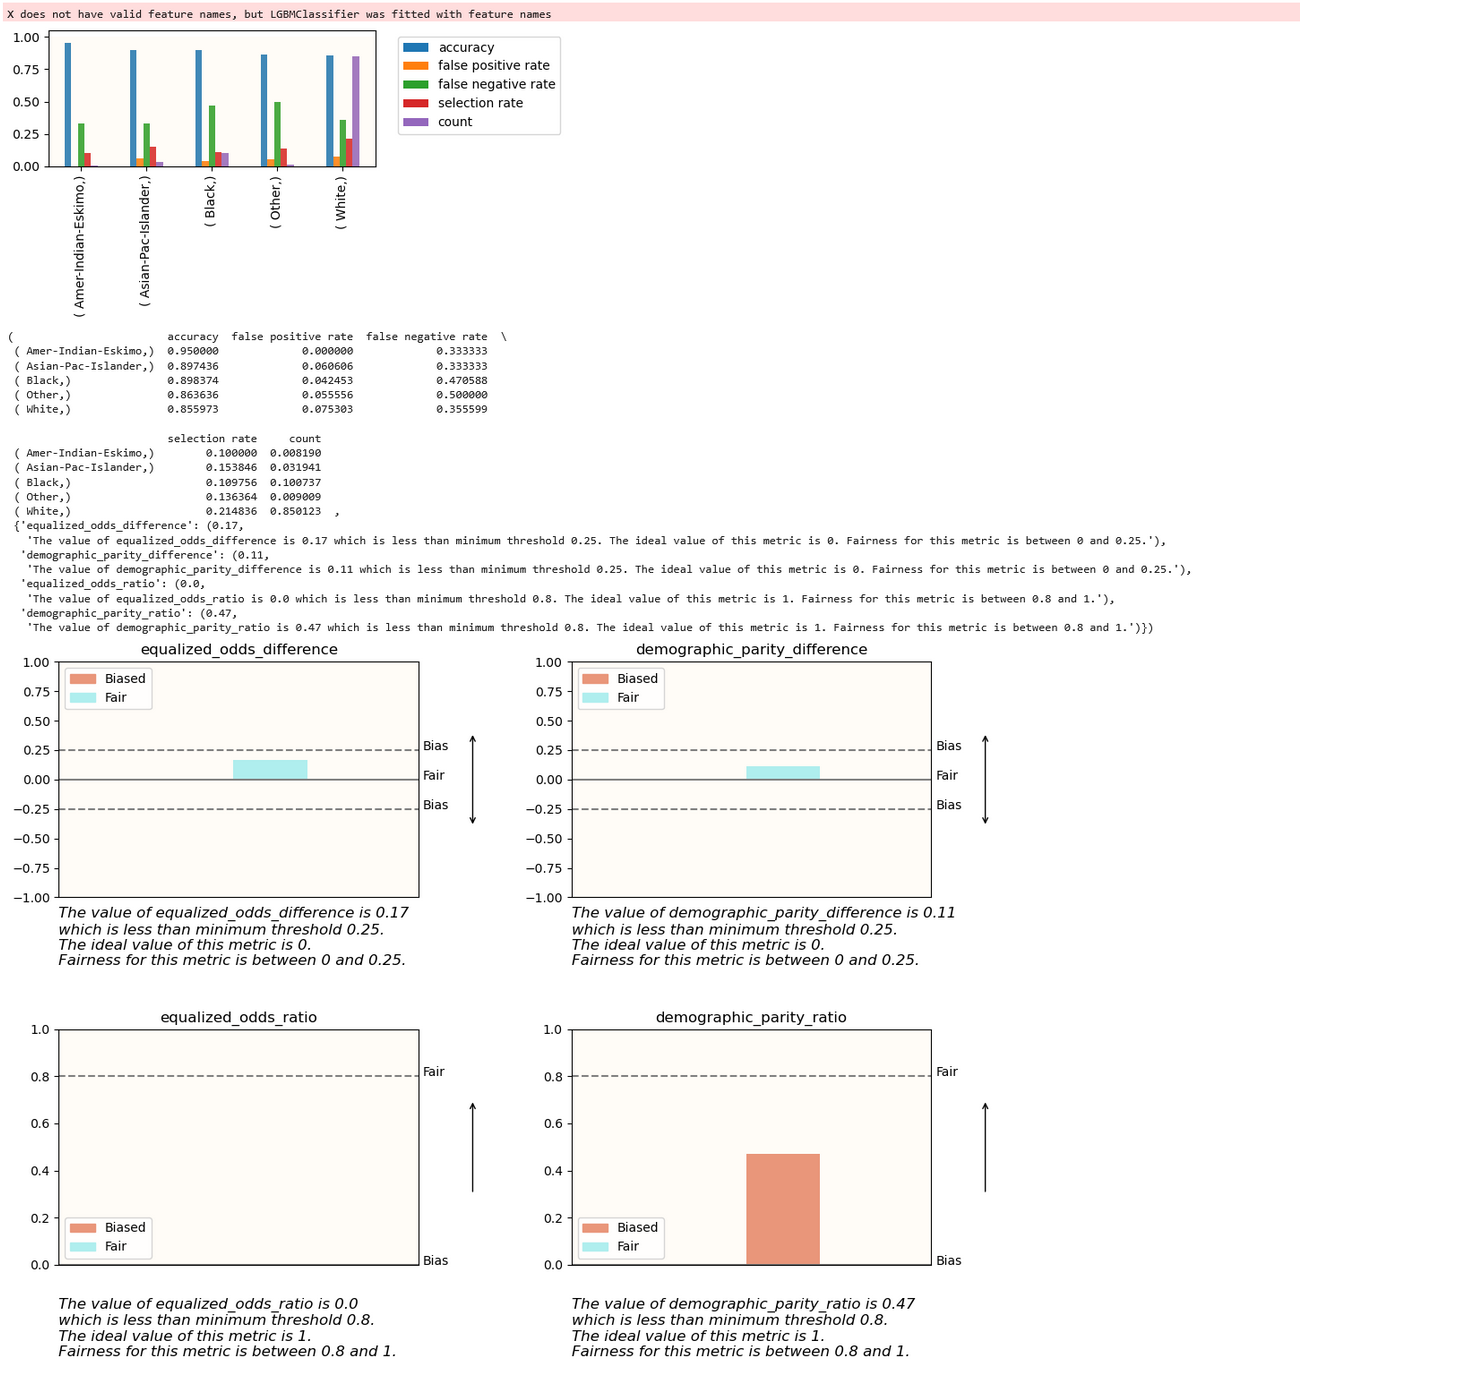

This will generate a report along with charts to inform the user if the fitted model is bias or unbiased. Based on this if the model is biased, then we do not need to proceed with the next following step. The biasness is measured based on these four metrics as mentioned in the report. If all the four metrics are within the allowed range of the respective metrics then the model is considered to be unbias. However in most cases it is unusual to get all the four metrics as unbiased. Due to data quality usually there are inbuilt biasness in at least one of these metrics. In such a scenario we will proceed with bias mitigation. 

[ ] 'equalized_odds_difference': (0.5,
   'The value of equalized_odds_difference is 0.5 which is more than minimum threshold 0.25. The ideal value of this metric is 0. Fairness for this metric is between 0 and 0.25.'),
[ ] 'demographic_parity_difference': (0.18,
   'The value of demographic_parity_difference is 0.18 which is less than minimum threshold 0.25. The ideal value of this metric is 0. Fairness for this metric is between 0 and 0.25.'),
  'equalized_odds_ratio': (0.0,
   'The value of equalized_odds_ratio is 0.0 which is less than minimum threshold 0.8. The ideal value of this metric is 1. Fairness for this metric is between 0.8 and 1.'),
  'demographic_parity_ratio': (0.21,
   'The value of demographic_parity_ratio is 0.21 which is less than minimum threshold 0.8. The ideal value of this metric is 1. Fairness for this metric is between 0.8 and 1.')})

#### Choosing a Metric<a id='choosing-metric'></a>  

If the primary concern is to ensure fairness in both false positives and false negatives, then Equalized Odds Ratio (EOR) would be the preferred metric for bias mitigation. Addressing disparities in both types of errors can lead to a more balanced and equitable outcome.

However, if the focus is solely on ensuring an equal distribution of positive outcomes between genders, then Demographic Parity Ratio (DPR) might be sufficient for mitigation efforts.

In the context of this example:

Equalized Odds Ratio (EOR):

EOR focuses on ensuring fairness in both false positives and false negatives between different males and females. Specifically, EOR (0.18) indicates that the odds of a true positive prediction for the protected group (e.g., females) are 18% of those for the unprotected group (e.g., males). Mitigating bias using EOR means adjusting the model to achieve more balanced error rates across genders, thereby reducing disparities in both types of prediction errors (false positives and false negatives).

Demographic Parity Ratio (DPR):

DPR primarily aims to ensure an equal distribution of positive outcomes (e.g. salary above 50k) between different genders, regardless of predictive errors. In this example, DPR (0.29) indicates that the ratio of positive outcomes for females is 29% of that for males. Mitigating bias using DPR involves adjusting the model to achieve parity in positive outcome rates across genders, without necessarily addressing disparities in prediction errors.

Following this diagnosis, we will now attempt to mitigate the demographic parity ratio bias caused by gender. First we will initialize the Mlmodel with the fairness metric for bias mitigation. 

### Bias mitigation for Classification <a id='mitigation-dpr'></a> 

The first step for mitigation is to identify a sensitive feature in the data that is introducing the bias and specify an appropriate mitigation_type and mitigation_constraint which is the fairness metric to be optimized and adjusted to achieve demographic parity in positive outcomes (salary) between different gender groups. This will be different for clasification and regression. To do this, here we initiate the model using the sensitive variable as Gender, and since it is a classification model we will define  `mitigation_type` as `threshold_optimizer` and `mitigation_constraint` as `demographic_parity`.

For classification:
mitigation_type can be  - reweighing or threshold_optimizer or exponentiated_gradient
mitigation_constraint can be:    demographic_parity or equalized_odds

Finally for the mitigating classification model we define the fairness_args as a dictionary using these as keys and arguments as follows:

In [ ]:
# Example fairness argument for classification
fairness_args = {'sensitive_feature': 'Race',
                 'mitigation_type': "threshold_optimizer",
                 'mitigation_constraint':'demographic_parity' 
                                                        }

After defining creating fairness_args we pass it as the fairness_args parameter while initiating the model for mitigation. 

In [ ]:
model = MLModel(data, "lightgbm.LGBMClassifier", fairness_args=fairness_args, n_estimators=500, random_state=43)

Now we will proceed to training the model. This is done by calling the fit method as shown below. 

In [ ]:
model.fit()

### Estimate Fairness of Mitigated Model <a class="anchor" id="10"></a>

Once the model is trained, it will have mitigated the bias. This can be verified by running the `fairness_score()` function again to evaluate whether the mitigated model has resolved the esixting bias in the model’s predictions with respect to the same specified sensitive feature or attribute of Gender. 

The model report below shows that now three indicator out of four has turned green. This suggests that bias mitigation has been successfully achieved. 

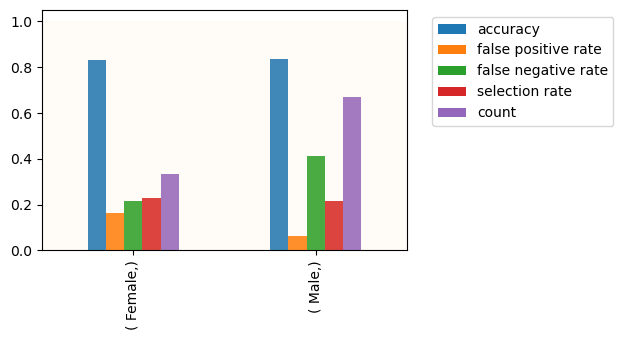

(            accuracy  false positive rate  false negative rate  \
 ( Female,)  0.829630             0.165062             0.216867   
 ( Male,)    0.834559             0.062446             0.413361   
 
             selection rate     count  
 ( Female,)        0.228395  0.331695  
 ( Male,)          0.216299  0.668305  ,
 {'equalized_odds_difference': (0.2,
   'The value of equalized_odds_difference is 0.2 which is less than minimum threshold 0.25. The ideal value of this metric is 0. Fairness for this metric is between 0 and 0.25.'),
  'demographic_parity_difference': (0.01,
   'The value of demographic_parity_difference is 0.01 which is less than minimum threshold 0.25. The ideal value of this metric is 0. Fairness for this metric is between 0 and 0.25.'),
  'equalized_odds_ratio': (0.38,
   'The value of equalized_odds_ratio is 0.38 which is less than minimum threshold 0.8. The ideal value of this metric is 1. Fairness for this metric is between 0.8 and 1.'),
  'demographic_parity_

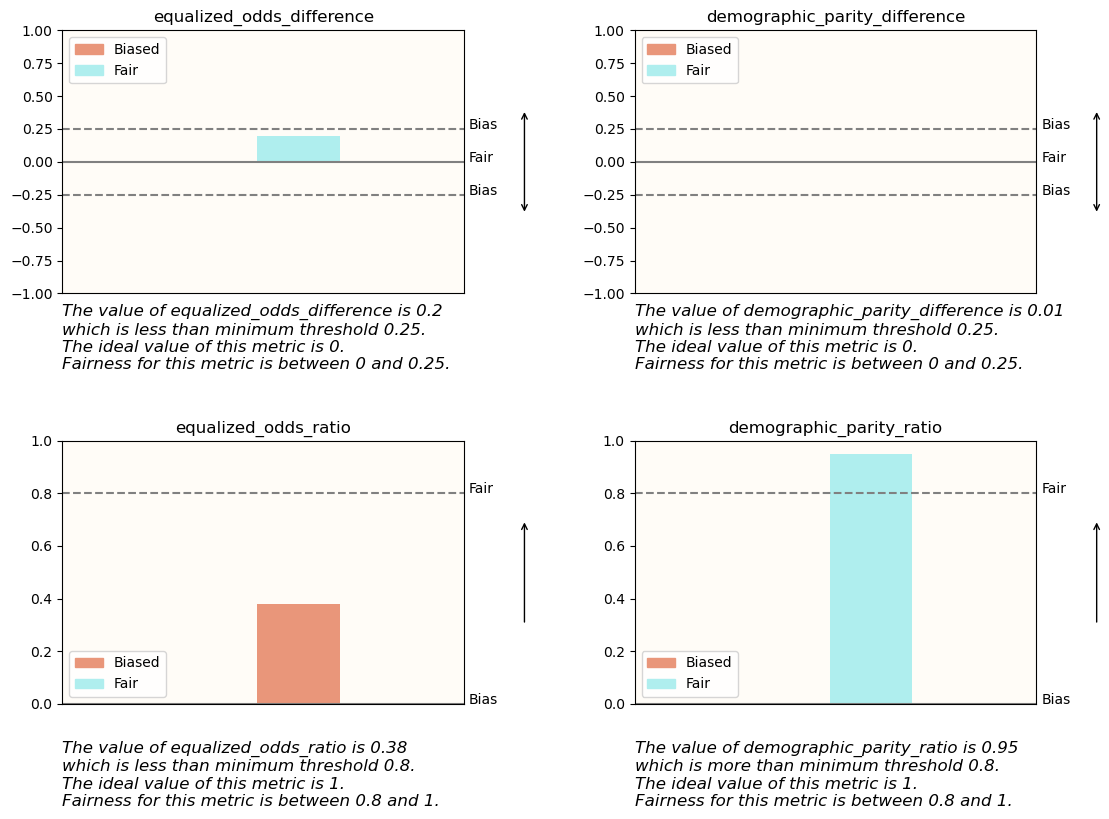

In [16]:
model.fairness_score(sensitive_feature ='Gender',visualize=True)

Fianlly we can now use this mitigated model to predict and validat to ensure that the performance remains consistent with previous evaluations, which should be approximately the same as before.

## Fairness Analysis for Regression

In case of regression models, we will follow a similar workflow. First the data is prepared by the `prepare_tabulardata` method where the `variable_predict` is a continuous variable. Here, for demonstration purpose, we ware using the `RandomForestRegressor` model from scikit-learn through the `MLModel` function, along with its parameters.

```python
from arcgis.learn import MLModel
model = MLModel(data, 'sklearn.ensemble.RandomForestRegressor', n_estimators=500, random_state=43)
```

In [ ]:
data = prepare_tabulardata(train,
                           'annual_salary_$',
                           explanatory_variables=X,              
                           )

In [ ]:
model = MLModel(data, 'sklearn.ensemble.RandomForestRegressor', n_estimators=500, random_state=43)
model.fit()

### Estimate Model Fairness of Base Model <a class="anchor" id="10"></a>

For example after training a model on predicitng salary data with Gender as one of the explanantory variables, we use the fairness score function with Gender as the sensitive feature to check if this is causing bais in the model. The following report is generated, which can be analysed to understand if the model has to be mitigated to remove this bias casused by this sensitive variable.

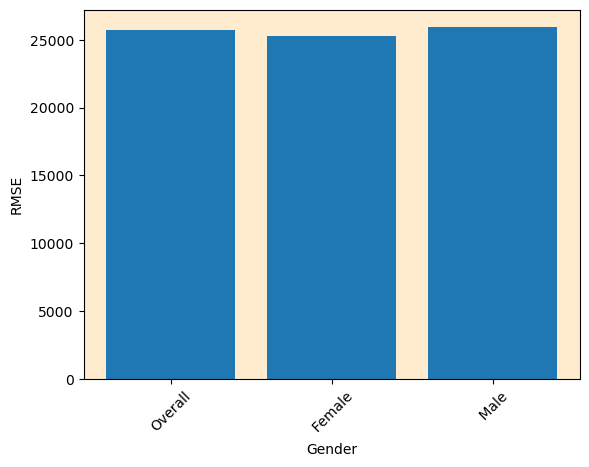

,fairness_metric_name,fairness_metric_diff,fairness_metric_ratio,is_ratio_fair,is_diff_fair
Gender,RMSE,-675.4206,1.0268,True,True


In [12]:
model.fairness_score(sensitive_feature ='Gender',visualize=True)

Analysis

    fairness_metric_diff = -675.4206:
    This indicates there is a difference of about 675.42 in RMSE between male and the female gender groups. The negative sign shows the direction of the difference, but the magnitude is the key factor. A difference of this size suggests some disparity in model error between genders.

    fairness_metric_ratio = 1.0268:
    The RMSE for one gender group is about 2.68% higher than the other. This ratio is fairly close to 1, indicating relatively small disparity.

    is_ratio_fair = True and is_diff_fair = True:
    Both boolean flags indicate that the difference and ratio are within acceptable fairness thresholds defined by your criteria.

Interpretation

    Although there is a noticeable RMSE difference (675.42), the model's performance disparity between genders is considered fair according to the thresholds used.

    The ratio close to 1 (1.0268) supports that the model predictions are fairly balanced between gender groups.

### Bias mitigation for Regression

We can see the expcept the large RMSE difference, the report before mitigation suggests that the base model is already quite fair with respect to gender. Though The fairness flags being True confirm that the model meets the fairness standards for gender, however the large RMSE difference seems to be an issue. Let us see if applying suitable mitigation strategy can improve this.  First we will define the fairness arguments as follows:

For regression:
mitigation_type can be - grid_search or exponentiated_gradient
mitigation_constraint: 'ZeroOneLoss' or 'SquareLoss'

In [13]:
# Example fairness argument for regression 
fairness_args = {'sensitive_feature': 'Gender',
                 'mitigation_type': "grid_search",
                 'mitigation_constraint':'ZeroOneLoss'
                }

Then using this arguments we initiate the regression model with the same algorithm as used for the base model, fit the model.

In [14]:
model = MLModel(data, 'sklearn.ensemble.RandomForestRegressor', fairness_args=fairness_args, n_estimators=500, random_state=43)

Initializing for Regression 


In [15]:
model.fit()

Fitting with grid_search


Finally we check the new fairness score of the mitigated model using the `fairness_score` function as follws:

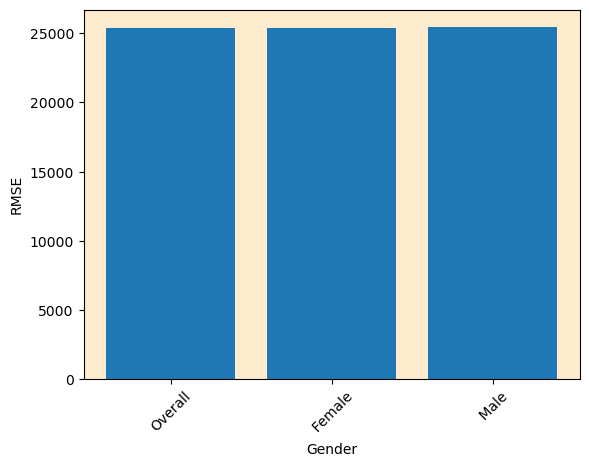

,fairness_metric_name,fairness_metric_diff,fairness_metric_ratio,is_ratio_fair,is_diff_fair
Gender,RMSE,-80.3214,1.0032,True,True


In [16]:
model.fairness_score(sensitive_feature ='Gender',visualize=True)

Explanation

    fairness_metric_diff = -80.3214:
    This value represents the difference in RMSE (Root Mean Squared Error) between gender groups. The negative sign indicates the direction of difference, but the magnitude (~80.32) is relatively small, suggesting a minor disparity in prediction error between genders.

    fairness_metric_ratio = 1.0032:
    This ratio means that the RMSE for one gender group is only about 0.32% higher than the other group, which is very close to perfect parity (ratio = 1).

    is_ratio_fair = True and is_diff_fair = True:
    Both boolean indicators confirm that the difference and ratio are within acceptable fairness thresholds. This implies the model treats gender groups fairly according to the defined criteria.

Interpretation

    The model shows very little disparity in error rates between genders, as reflected by the small RMSE difference and ratio close to 1.

    The fairness flags being True confirm that the model meets the fairness standards for gender.

    If this is indeed the before mitigation report, it suggests that the base model was already quite fair with respect to gender.

Summary Comparison (Gender Before vs After Mitigation)
Metric	Before Mitigation	After Mitigation
fairness_metric_diff	-675.4206	-80.3214
fairness_metric_ratio	1.0268	1.0032
is_ratio_fair	True	True
is_diff_fair	True	True

    The difference in RMSE decreased substantially after mitigation (from ~675 to ~80).

    The ratio moved closer to perfect parity (from 1.0268 to 1.0032).

    Both models meet fairness criteria, but mitigation clearly improved fairness by reducing disparity.

Conclusion

    The base model before mitigation was fair but showed moderate disparity in error rates between genders.

    Mitigation efforts successfully reduced this disparity, leading to a more balanced and fair model.

    Monitoring both difference and ratio metrics is important to ensure fairness across sensitive groups.